# School students final grade prediction

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

### libraries 

In [354]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math

import warnings
warnings.filterwarnings('ignore')

In [272]:
df_file = './student-mat.csv'

In [380]:
df = pd.read_csv(df_file, sep=',')

In [381]:
df.head(4)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15


In [80]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [295]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
dtype: object

In [82]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


#### missing values

In [83]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

### Categorical values

In [357]:
df_cat_features = df.select_dtypes(include=['object'])
df_cat_features.columns


Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

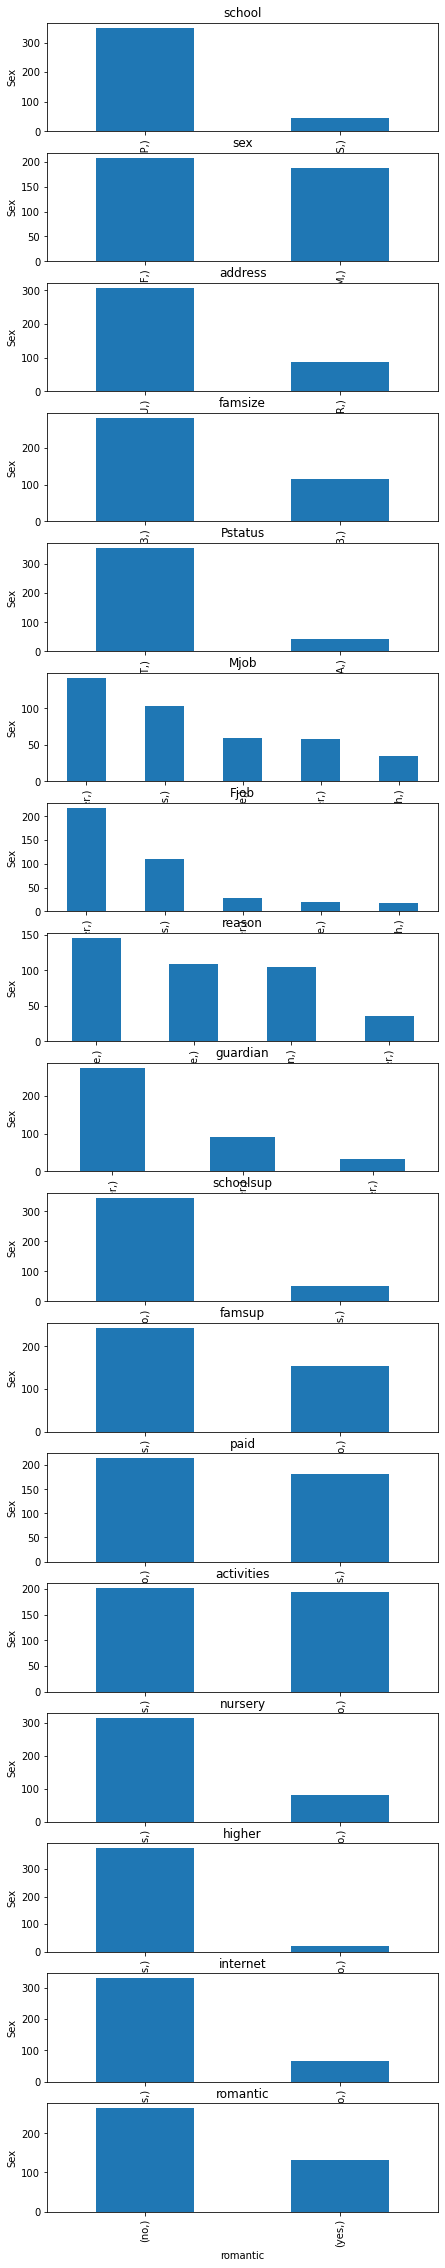

In [358]:
fig, axs = plt.subplots(17, 1, figsize=(7,16))
plt.subplots_adjust(bottom=0.1, top=2)
i = 1

while i <= 17:
    plt.subplot(17, 1, i)
    df_cat_features.iloc[:, [i-1]].value_counts().plot(kind='bar').set_title(df_cat_features.columns[i-1])
    plt.ylabel('Sex')
    i += 1

plt.show()

Text(0.5, 1.0, 'Outliers in the dataset')

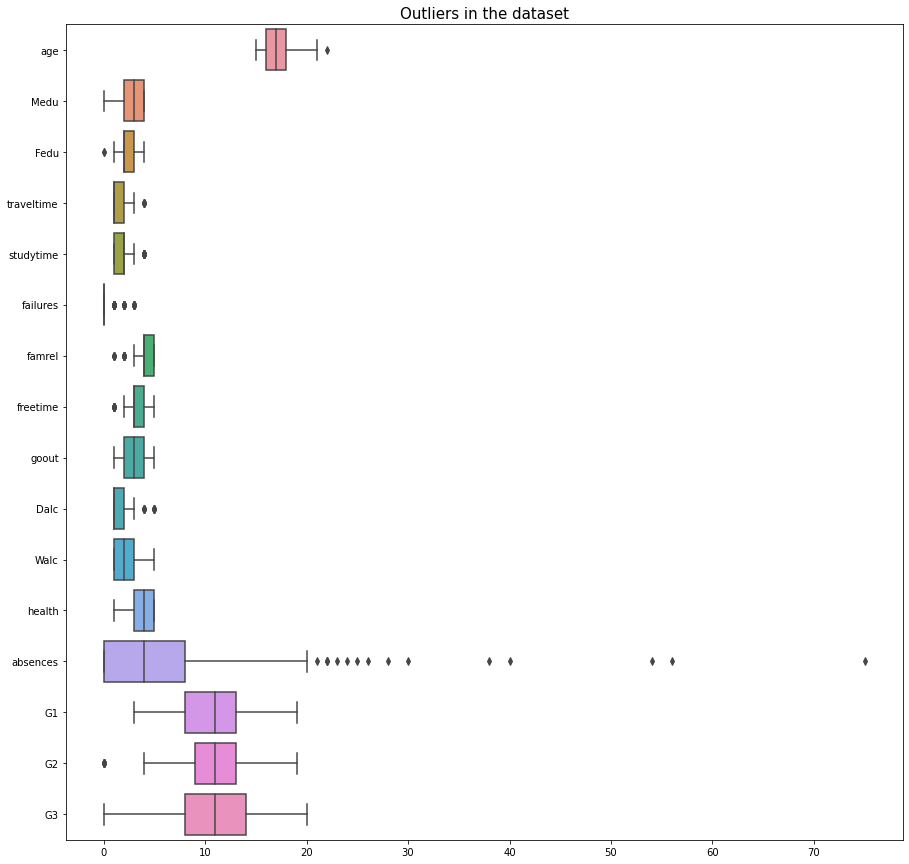

In [359]:
plt.figure(figsize=(15,15))
#sns.set_theme(style="ticks", font_scale=1.1)
sns.boxplot(data=df, orient='h')
plt.title('Outliers in the dataset', size=15)

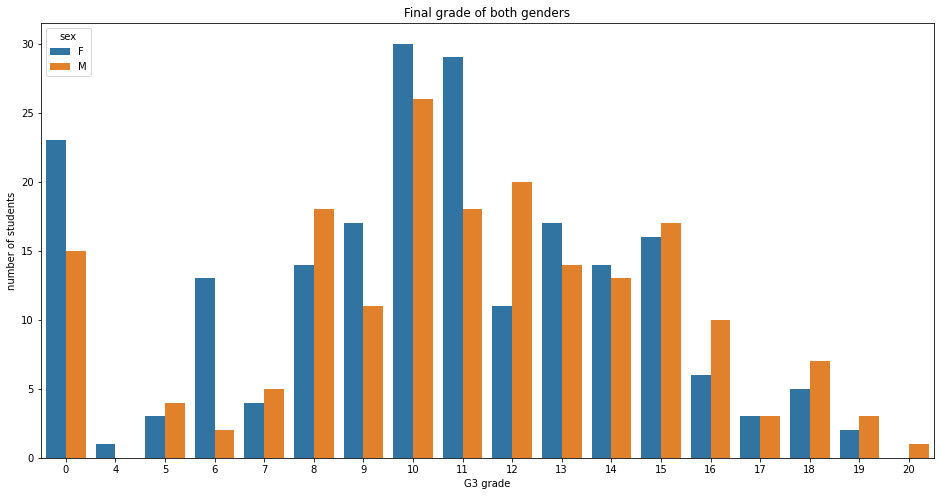

In [383]:
plt.figure(figsize = (16, 8))
sns.countplot(data=df, x='G3', hue = 'sex')
plt.xlabel("G3 grade")
plt.ylabel("number of students")
plt.title('Final grade of both genders')
plt.show()

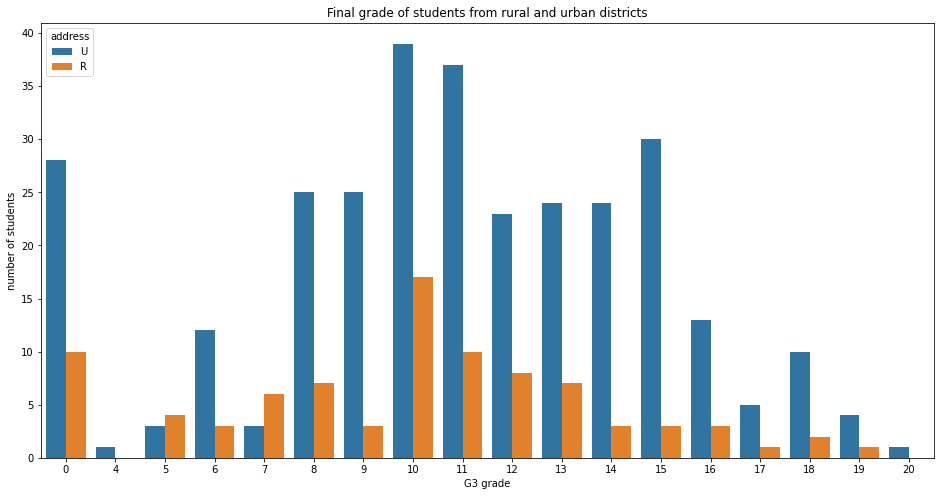

In [384]:
plt.figure(figsize = (16, 8))
sns.countplot(data=df, x='G3', hue = 'address')
plt.xlabel("G3 grade")
plt.ylabel("number of students")
plt.title('Final grade of students from rural and urban districts')
plt.show()

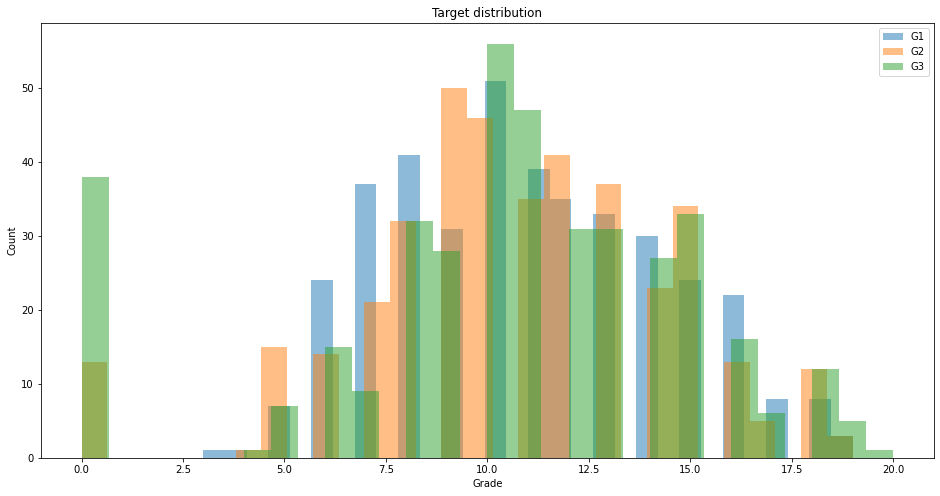

In [362]:
# let's see the distribution of Targets
plt.figure(figsize = (16, 8))

plt.hist(df['G1'], bins=30, alpha = 0.5)
plt.hist(df['G2'], bins=30, alpha = 0.5)
plt.hist(df['G3'], bins=30, alpha = 0.5)

plt.ylabel('Count')
plt.xlabel('Grade')

plt.legend(['G1', 'G2', 'G3'])


plt.title('Target distribution')
plt.show()

### Features engineering

In [368]:
y = df.pop("G3")
X = df

In [369]:
#Let’s split X and y using Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state= 42)
#get shape of train and test data
print("train data size:",X_train.shape)
print("test data size:",X_test.shape)

train data size: (316, 32)
test data size: (79, 32)


In [363]:
categorical_feastures = ['school',\
                           'sex',\
                           'address',\
                           'famsize',\
                           'Pstatus',\
                           'Mjob',\
                           'Fjob',\
                           'reason',\
                           'guardian',\
                           'schoolsup',\
                           'famsup',\
                           'paid',\
                           'activities',\
                           'nursery',\
                           'higher',\
                           'internet',\
                           'romantic',
                        ]

In [364]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.00,-0.16,-0.16,0.07,-0.00,0.24,0.05,0.02,0.13,0.13,0.12,-0.06,0.18,-0.06,-0.14,-0.16
Medu,-0.16,1.00,0.62,-0.17,0.06,-0.24,-0.00,0.03,0.06,0.02,-0.05,-0.05,0.10,0.21,0.22,0.22
Fedu,-0.16,0.62,1.00,-0.16,-0.01,-0.25,-0.00,-0.01,0.04,0.00,-0.01,0.01,0.02,0.19,0.16,0.15
traveltime,0.07,-0.17,-0.16,1.00,-0.10,0.09,-0.02,-0.02,0.03,0.14,0.13,0.01,-0.01,-0.09,-0.15,-0.12
studytime,-0.00,0.06,-0.01,-0.10,1.00,-0.17,0.04,-0.14,-0.06,-0.20,-0.25,-0.08,-0.06,0.16,0.14,0.10
failures,0.24,-0.24,-0.25,0.09,-0.17,1.00,-0.04,0.09,0.12,0.14,0.14,0.07,0.06,-0.35,-0.36,-0.36
famrel,0.05,-0.00,-0.00,-0.02,0.04,-0.04,1.00,0.15,0.06,-0.08,-0.11,0.09,-0.04,0.02,-0.02,0.05
freetime,0.02,0.03,-0.01,-0.02,-0.14,0.09,0.15,1.00,0.29,0.21,0.15,0.08,-0.06,0.01,-0.01,0.01
goout,0.13,0.06,0.04,0.03,-0.06,0.12,0.06,0.29,1.00,0.27,0.42,-0.01,0.04,-0.15,-0.16,-0.13
Dalc,0.13,0.02,0.00,0.14,-0.20,0.14,-0.08,0.21,0.27,1.00,0.65,0.08,0.11,-0.09,-0.06,-0.05


In [365]:
corr['G3'].abs().sort_values(ascending=False)

G3            1.000000
G2            0.904868
G1            0.801468
failures      0.360415
Medu          0.217147
age           0.161579
Fedu          0.152457
goout         0.132791
traveltime    0.117142
studytime     0.097820
health        0.061335
Dalc          0.054660
Walc          0.051939
famrel        0.051363
absences      0.034247
freetime      0.011307
Name: G3, dtype: float64

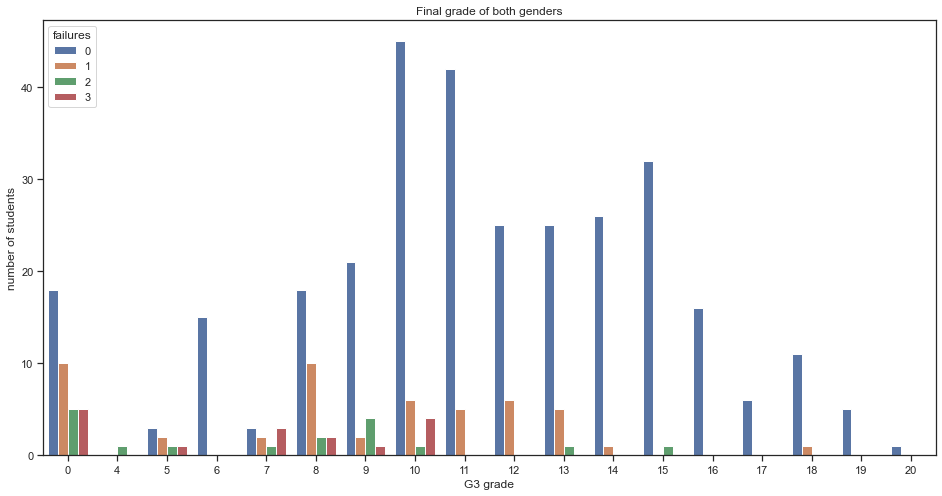

In [401]:
plt.figure(figsize = (16, 8))
sns.countplot(data=df, x='G3', hue = 'failures')
plt.xlabel("G3 grade")
plt.ylabel("number of students")
plt.title('Final grade of both genders')
plt.show()

### CatBoostRegressor

We don't need to create dummy variables for categorical columns since we’re using CatBoost, which doesn’t need categorical variables to be preprocessed like one hot encoding.

In [315]:
y = df.pop("G3")
X = df

In [316]:
#Let’s split X and y using Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state= 42)
#get shape of train and test data
print("train data size:",X_train.shape)
print("test data size:",X_test.shape)

train data size: (316, 32)
test data size: (79, 32)


In [317]:
print("Names of categorical columns : ", categorical_feastures)
#Get location of categorical columns
cat_features = [X.columns.get_loc(col) for col in categorical_feastures]
print("Location of categorical columns : ",cat_features)

Names of categorical columns :  ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Location of categorical columns :  [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22]


In [318]:
# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )
#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

In [319]:
#build model
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit(X_train,
              y_train,
              cat_features = categorical_feastures,
              eval_set = (X_test, y_test),
              early_stopping_rounds = 50,
              use_best_model = True,
              verbose = False)

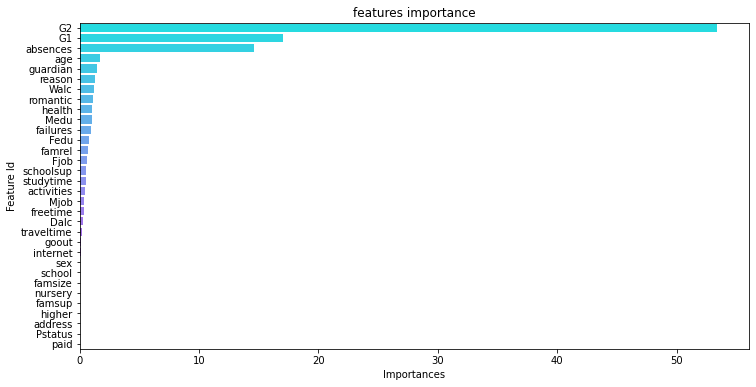

In [320]:
# Create a dataframe of feature importance 
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance');

### model evaluation

In [321]:
y_predict= cat_model.predict(X_test)
#RMSE
Rmse_test = math.sqrt(mean_squared_error(y_test,y_predict))
#R2 Score
r2_test = r2_score(y_test,y_predict)
# Adjusted R2 Score
n= X_train.shape[0] # total no of datapoints
p= X_train.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))

Evaluation on test data
RMSE: 1.85
R2: 0.83
Adjusted R2: 0.81


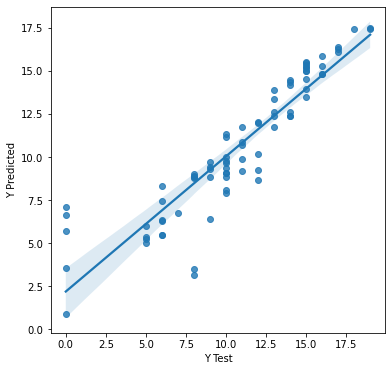

In [351]:
plt.figure(figsize=(6,6))

sns.regplot(y_test, y_predict)
plt.xlabel('Y Test')
plt.ylabel('Y Predicted')
plt.show()

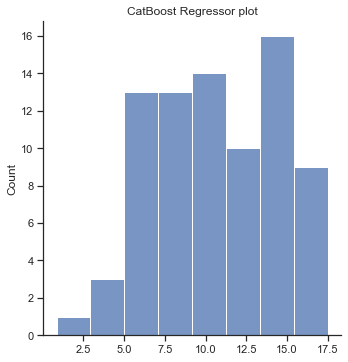

In [402]:
sns.displot(y_predict)
plt.title("CatBoost Regressor plot")
plt.show()